In [1]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from impyute.imputation.cs import fast_knn
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, recall_score, average_precision_score
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### loading the file and applying knn-imputation after encoding

In [2]:
df = pd.read_csv('dataset.txt', encoding='ISO-8859-1', delimiter='\t', dtype=str)
X = pd.get_dummies(df.iloc[:, 2:13])
new_columns = X.columns
labels = df.iloc[:, 2:13].columns
for feature_name in labels:
    X.loc[df.iloc[:, 2:13][feature_name].isnull(), X.columns.str.startswith(feature_name+'_')] = np.nan
X = np.array(X)
imputed_X=np.rint(fast_knn(X, k=30))
sc = StandardScaler()
X = sc.fit_transform(imputed_X)
y = df.iloc[:, 0]
y = np.where(y=='kontrol',0,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=40)
lr_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=10000)
svm_clf = SVC(gamma='auto', probability=True)

### calculating auc scores and plotting ROC in approach A

In [3]:
def getROCScores(classifier, X_train, y_train, X_test, y_test, label):
    classifier.fit(X_train, y_train)
    probs = classifier.predict_proba(X_test)
    probs = probs[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    return auc, fpr, tpr, thresholds, label

In [4]:
def plotROC(scores, title, filename):
    plt.plot(scores[0][1], scores[0][2], marker='.', color='black', label='{}: {}'.format(scores[0][4], round(scores[0][0],2)))
    plt.plot(scores[1][1], scores[1][2], marker='.', color='red', label='{}: {}'.format(scores[1][4], round(scores[1][0],2)))
    plt.plot(scores[2][1], scores[2][2], marker='.', color='blue', label='{}: {}'.format(scores[2][4], round(scores[2][0],2)))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title(title)
    plt.legend()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

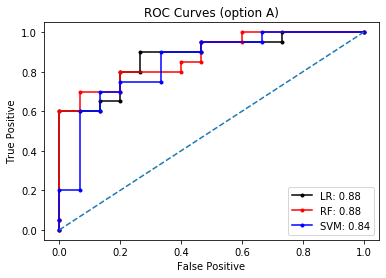

In [5]:
roc_lr = getROCScores(lr_clf, X_train, y_train, X_test, y_test, 'LR')
roc_rf = getROCScores(rf_clf, X_train, y_train, X_test, y_test, 'RF')
roc_svm = getROCScores(svm_clf, X_train, y_train, X_test, y_test, 'SVM')
plotROC([roc_lr, roc_rf, roc_svm], 'ROC Curves (option A)', 'roc_curves (option A)')

### plotting important features in approach A

In [6]:
def feature_importance(X_train, y_train, title, filename, labels):
    feat_labels = labels
    rf_clf.fit(X_train, y_train)
    importances = rf_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(15,5))
    plt.title(title)
    plt.bar(range(X_train.shape[1]), importances[indices], color='lightgreen', align='center')
    plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
    plt.xlim([-1, X_train.shape[1]])
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

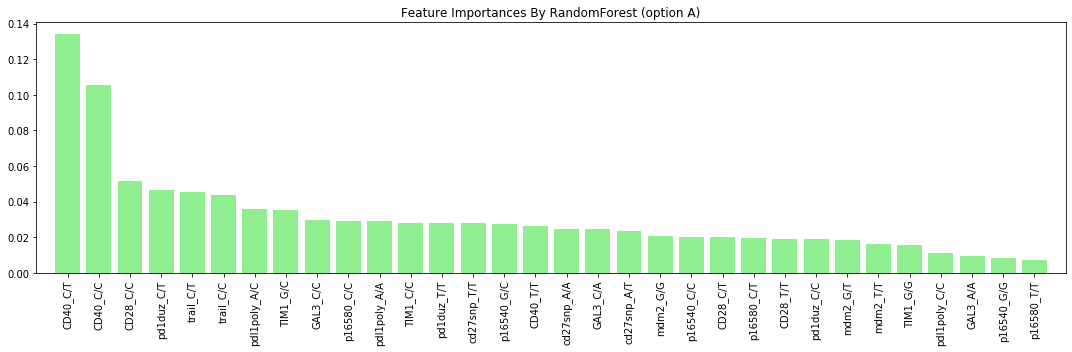

In [7]:
features_title = 'Feature Importances By RandomForest (option A)'
feature_importance(X_train, y_train, features_title, 'feature_importance (option A)', new_columns)